## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(num_training=5000, num_validation=1000, num_test=2000)
# X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (5000, 32, 32, 3)
Train labels shape:  (5000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (2000, 32, 32, 3)
Test labels shape:  (2000,)


In [3]:
def run_model(writer, merged, session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [merged, mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            summary, loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            writer.add_summary(summary, i)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct



In [4]:
def my_model(X,y,is_training):
    #32x32x3
    net = tf.layers.conv2d(X, filters=8, kernel_size=[3,3], padding='same',
                           activation=tf.nn.relu)
    #32x32x8
    net = tf.layers.max_pooling2d(net, pool_size=[2,2], strides=2)
    
    #16x16x8
    net = tf.layers.batch_normalization(net, training=is_training)
    net = tf.layers.conv2d(net, filters=16, kernel_size=[3,3], padding='same',
                          activation=tf.nn.relu)
    #16x16x16
    net = tf.layers.max_pooling2d(net, pool_size=[2,2], strides=2)
    
    #8x8x16
    net = tf.layers.batch_normalization(net, training=is_training)
    net = tf.layers.conv2d(net, filters=32, kernel_size=[3,3], padding='same',
                          activation=tf.nn.relu)
    #8x8x32
    net = tf.layers.max_pooling2d(net, pool_size=[2,2], strides=2)
    
    #4x4x32
    net = tf.reshape(net, [-1, 4*4*32])
    # nx(4*4*32) = nx512
    net = tf.layers.dense(net, units=256, activation=tf.nn.relu)
    net = tf.layers.dropout(net, rate=0.5, training=is_training)
    # nx256 (note: no activation in the last layer)
    net = tf.layers.dense(net, units=10)
    # nx10
    return net

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
mean_loss = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
tf.summary.scalar("cross_entropy_loss", mean_loss)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.77 and accuracy of 0.094
Epoch 1, Overall loss = 2.06 and accuracy of 0.265


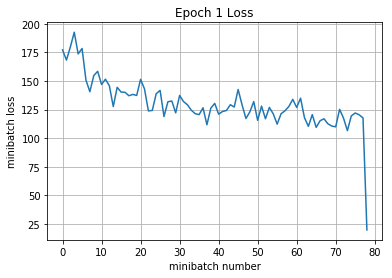

Validation
Epoch 1, Overall loss = 2.06 and accuracy of 0.254


In [5]:
# from tensorflow.python import debug as tf_debug
merged=tf.summary.merge_all()
sess = tf.Session()
# sess = tf_debug.TensorBoardDebugWrapperSession(sess, "e9a3475a5764:6005")
writer = tf.summary.FileWriter(logdir="/tmp/f5/...", graph=sess.graph)
sess.run(tf.global_variables_initializer())
print('Training')
run_model(writer, merged, sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
print('Validation')
run_model(writer, merged, sess,y_out,mean_loss,X_val,y_val,1,64)
writer.close()

In [6]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
# print('Training')
# run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
# print('Validation')
# run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [7]:
# print('Test')
# run_model(sess,y_out,mean_loss,X_test,y_test,1,64)